# Capture the Flag (RL - Policy Gradient)

- Seung Hyun Kim
- skim449@illinois.edu

## Notes
- This notebook includes:
    - Building the structure of policy driven network.
    - Training with/without render
    - Saver that save model and weights to ./model directory
    - Writer that will record some necessary datas to ./logs
- This notebook does not include running the CtF game with the RL policy. Using the network will be separately scripted in policy/policy_RL1.py.
    - cap_test.py is changed appropriately.
    
## References :
- https://github.com/awjuliani/DeepRL-Agents/blob/master/Vanilla-Policy.ipynb (source)
- https://www.youtube.com/watch?v=PDbXPBwOavc

In [1]:
TRAIN_NAME='NO_RED_02_RMS'
LOG_PATH='./logs/'+TRAIN_NAME
MODEL_PATH='./model/' + TRAIN_NAME
GPU_CAPACITY=0.25 # gpu capacity in percentage

In [2]:
import os

import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
%matplotlib inline

import time
import gym
import gym_cap
import gym_cap.envs.const as CONST
import numpy as np
import random

# the modules that you can use to generate the policy.
import policy.patrol 
import policy.random
import policy.simple # custon written policy
import policy.policy_RL
import policy.zeros

# Data Processing Module
from DataModule import one_hot_encoder, VISION_dX, VISION_dY

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


## Environment Setting

In [3]:
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
    
#Create a directory to save episode playback gifs to
if not os.path.exists(LOG_PATH):
    os.makedirs(LOG_PATH)

In [4]:
env = gym.make("cap-v0") # initialize the environment
policy_red = policy.random.PolicyGen(env.get_map, env.get_team_red)

print('red number : ', len(env.get_team_red))
print('blue number : ', len(env.get_team_blue))

red number :  0
blue number :  4


## Discount Reward

In [5]:
gamma = 0.98

def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0.0
    for t in reversed(range(r.size)):
        running_add = (running_add * gamma + r[t])
        discounted_r[t] = running_add
    #discounted_r = (discounted_r - np.mean(discounted_r)) / (np.std(discounted_r)+1e-8) # normalize
    return discounted_r

## Network Setting

In [6]:
class agent():
    def __init__(self, lr, in_size,action_size):
        #These lines established the feed-forward part of the network. The agent takes a state and produces an action.
        self.state_input = tf.placeholder(shape=in_size,dtype=tf.float32, name='state')
        
        layer = slim.conv2d(self.state_input, 16, [5,5], activation_fn=tf.nn.relu,
                            padding='SAME',
                            scope='conv1')
        #layer = slim.avg_pool2d(layer, [2,2])
        layer = slim.conv2d(layer, 16, [3,3], activation_fn=tf.nn.relu,
                            padding='SAME',
                            scope='conv2')
        layer = slim.flatten(layer)
        #flat  = tf.reshape(conv, [-1, VISION_dX*VISION_dY*128])
        #layer = slim.dropout(layer,keep_prob=0.8)
        #layer = slim.fully_connected(layer, 516,
        #                            activation_fn=tf.nn.relu,
        #                            biases_initializer=None,
        #                            scope='hidden_fc1')
        layer = slim.dropout(layer,keep_prob=0.8)
        layer = slim.fully_connected(layer, 1024,
                                    activation_fn=tf.nn.relu,
                                    biases_initializer=None)
        self.dense = slim.fully_connected(layer, action_size,
                                     activation_fn=tf.nn.relu,
                                     biases_initializer=None,
                                     scope='output_fc')
        self.output = tf.nn.softmax(self.dense, name='action')
        
        tf.summary.histogram('output', self.output)
        
        with tf.name_scope('weights'):
            for var in slim.get_model_variables():
                tf.summary.histogram(var.op.name, var)

        #The next six lines establish the training proceedure. We feed the reward and chosen action into the network
        #to compute the loss, and use it to update the network.
    
        with tf.name_scope('action_placement'):
            self.action_holder = tf.placeholder(shape=[None],dtype=tf.int32)
            self.indexes = tf.range(0, tf.shape(self.output)[0]) * tf.shape(self.output)[1] + self.action_holder

        with tf.name_scope('loss'):
            self.reward_holder = tf.placeholder(shape=[None],dtype=tf.float32)
            self.responsible_outputs = tf.gather(tf.reshape(self.dense, [-1]), self.indexes) # output
            self.loss = -tf.reduce_mean(tf.log(self.responsible_outputs)*self.reward_holder)

        tvars = tf.trainable_variables()
        self.gradient_holders = []
        for idx,var in enumerate(tvars):
            placeholder = tf.placeholder(tf.float32,name=str(idx)+'_holder')
            self.gradient_holders.append(placeholder)
        
        with tf.name_scope('gradients'):
            self.gradients = tf.gradients(self.loss,tvars)

        with tf.name_scope('optimizer'):
            optimizer = tf.train.RMSPropOptimizer(learning_rate=lr)
            self.update_batch = optimizer.apply_gradients(zip(self.gradient_holders,tvars))

In [7]:
tf.reset_default_graph() # Clear the Tensorflow graph.
myAgent = agent(lr=1e-5,in_size=[None,VISION_dX,VISION_dY,6],action_size=5) #Load the agent.
global_step = tf.Variable(0, trainable=False, name='global_step') # global step
increment_global_step_op = tf.assign(global_step, global_step+1)
merged = tf.summary.merge_all()

/home/namsong/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Hyperparameters

In [8]:
# Training Related
total_episodes = 20000 #Set total number of episodes to train agent on.
max_ep = 300
update_frequency = 100
batch_size = 2000

# Saving Related
save_network_frequency = 100
save_stat_frequency = 50
moving_average_step = 50

# Environment Related
action_space = 5
n_agent = len(env.get_team_blue)

## Session

In [9]:
# Launch the session
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=GPU_CAPACITY)

sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
#sess = tf.Session()

total_reward = []
total_length = []
total_captured = []

# Setup Save and Restore Network
saver = tf.train.Saver(tf.global_variables())
writer = tf.summary.FileWriter(LOG_PATH, sess.graph)

ckpt = tf.train.get_checkpoint_state(MODEL_PATH)
if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
    saver.restore(sess, ckpt.model_checkpoint_path)
    print("Load Model : ", ckpt.model_checkpoint_path)
else:
    sess.run(tf.global_variables_initializer())
    print("Initialized Variables")

Initialized Variables


In [10]:
def record(obs):
    with tf.device('/cpu:0'): 
        summary = tf.Summary()
        summary.value.add(tag='Records/mean_reward', simple_value=np.mean(total_reward[-moving_average_step:]))
        summary.value.add(tag='Records/mean_length', simple_value=np.mean(total_length[-moving_average_step:]))
        summary.value.add(tag='Records/mean_succeed', simple_value=np.mean(total_captured[-moving_average_step:]))
        writer.add_summary(summary, sess.run(global_step))
        
        summary_str = sess.run(merged,feed_dict={myAgent.state_input:obs})
        writer.add_summary(summary_str, sess.run(global_step))
        
        writer.flush()

In [11]:
gradBuffer = sess.run(tf.trainable_variables())
def clear_buffer():
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0 #np.zeros(grad.shape)

In [12]:
class Experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
    
    def flush(self):
        self.buffer = []
        self.buffer_size = 0
    
    def sample(self, size=2000):
        if size > len(self.buffer):
            return np.array(self.buffer)
        else:
            return np.reshape(np.array(random.sample(self.buffer,size)),[size,3])

In [13]:
def policy_rollout(env, explore=False):
    # Run single episode, return the results (number of frame, history, total reward, game_won, last obs)
    s = env.reset(map_size=20, policy_red=policy_red)
    ep_history = []
    indv_history = [[] for _ in range(len(env.get_team_blue))]
    
    was_alive = [ag.isAlive for ag in env.get_team_blue]
    prev_reward=0
    for frame in range(max_ep+1):
        #obs = one_hot_encoder(s, env.get_team_blue).tolist() # partial observation
        obs = one_hot_encoder(env._env, env.get_team_blue) # Full observation
        
        if explore:
            act = np.random.randint(action_space, size=n_agent).tolist()
        else:
            with tf.device('/cpu:0'):        
                #Probabilistically pick an action given our network outputs.
                act_prob = sess.run(myAgent.output, feed_dict={myAgent.state_input:obs})
                act = [np.random.choice(action_space, p=act_prob[x]/sum(act_prob[x])) for x in range(n_agent)] # divide by sum : normalize
            
        s,r,d,_ = env.step(act) #Get our reward for taking an action given a bandit.
        
        # If frame is at max and the game is still not done, negative reward
        if frame == max_ep and d == False:
            #r -= frame * (30/150)
            r -= 30
            
        # Push history for individual that 'was' alive previous frame
        for idx, agent in enumerate(env.get_team_blue):
            if was_alive[idx]: indv_history[idx].append([obs[idx],act[idx],r])

        # If reward sequence change, push the history into the episode history.
        if prev_reward != r:
            for idx, history in enumerate(indv_history):
                if len(history)==0: continue
                if not was_alive[idx]: continue
                _history = np.array(history)
                _history[:,2] = discount_rewards(_history[:,2])
                ep_history.extend(_history)
        
        # State Transition
        frame += 1
        prev_reward = r
        was_alive = [ag.isAlive for ag in env.get_team_blue]
        
        if d == True:
            break
    if len(ep_history) > 0:        
        ep_history = np.stack(ep_history)
    
    return [frame, ep_history, r, env.game_won, obs]

## Training

   35/20000 [.....] - ETA: 7:44:22

Manually stopped the training (KeyboardInterrupt)
save:  35 episodes


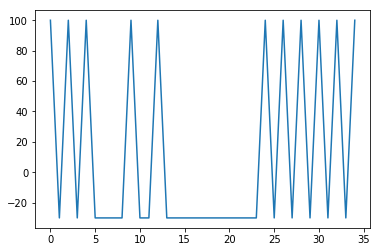

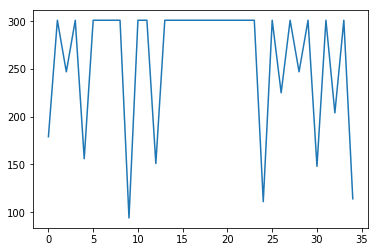

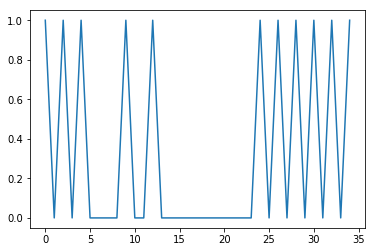

In [14]:
if __name__=='__main__':
    ep = 0

    exploration_count = 20
    exp_buffer = Experience_buffer()
    clear_buffer()
    try:
        progbar = tf.keras.utils.Progbar(total_episodes,width=5)
        while ep < total_episodes+1:
            progbar.update(ep) # update progress bar

            # Run episode
            frame, history, reward, did_won, obs = policy_rollout(env, exploration_count > ep)

            # Add history
            exp_buffer.add(history)

            if exploration_count < ep:
                with tf.device('/gpu:0'):
                    batch_history = exp_buffer.sample(batch_size) # Sample from experience replay
                    feed_dict={myAgent.reward_holder:batch_history[:,2],
                               myAgent.action_holder:batch_history[:,1],
                               myAgent.state_input:np.stack(batch_history[:,0])}
                    grads = sess.run(myAgent.gradients, feed_dict=feed_dict)

                    for idx,grad in enumerate(grads):
                        gradBuffer[idx] += grad
                    if ep % update_frequency == 0 and ep != 0:
                        feed_dict= dictionary = dict(zip(myAgent.gradient_holders, gradBuffer))
                        with tf.device('/gpu:0'):
                            _ = sess.run(myAgent.update_batch, feed_dict=feed_dict)
                        clear_buffer()
                    exp_buffer.flush()

            total_reward.append(reward)
            total_length.append(frame)
            total_captured.append(env.game_won)
            if ep % save_stat_frequency == 0 and ep != 0:
                record(obs)

            # save every 100 ep
            if ep % save_network_frequency == 0 and ep != 0:
                print(' Average r : ', np.mean(total_reward[-save_network_frequency:]))
                saver.save(sess, MODEL_PATH+'/ctf_policy.ckpt', global_step=global_step)
                print("save weights: ", sess.run(global_step), 'episodes')

            ep += 1
            sess.run(increment_global_step_op)

    except KeyboardInterrupt:
        print('\n\nManually stopped the training (KeyboardInterrupt)');
        plt.plot(total_reward)
        plt.figure()
        plt.plot(total_length)
        plt.figure()
        plt.plot(total_captured)
        saver.save(sess, MODEL_PATH+'/ctf_policy.ckpt', global_step=global_step)
        record(obs)
        print("save: ", sess.run(global_step), 'episodes')